# <span style="color:orange">**External Data Preparation**</span>
___
___

### <u>Objective:</u> get daily temperatures and max wind speed.

### <u>Source of external data:</u>  https://www.ncei.noaa.gov/data/global-summary-of-the-day/

### <u>Notebook purposes:</u>
- Condense all data downloaded (from 2015 to 2023) into one single dataframe.
- The result df will be provided for inference.

___
___
# **Librairies**

In [1]:
from utility_script_dynamic_rythms import *

___
___
# **Open Data**
- Source : https://www.ncei.noaa.gov/data/global-summary-of-the-day/
- Data description : 

| Column    | Description                                                                                     | Unit/Precision                       |
|---------|-------------------------------------------------------------------------------------------------|----------------------------|
| EMP     | Mean temperature                                                                                | 0.1 °F                     |
| DEWP    | Mean dew point                                                                                  | 0.1 °F                     |
| SLP     | Mean sea level pressure                                                                         | 0.1 mb                     |
| STP     | Mean station pressure                                                                           | 0.1 mb                     |
| VISIB   | Mean visibility                                                                                 | 0.1 miles                  |
| WDSP    | Mean wind speed                                                                                 | 0.1 knots                  |
| MXSPD   | Maximum sustained wind speed                                                                    | 0.1 knots                  |
| GUST    | Maximum wind gust                                                                               | 0.1 knots                  |
| MAX     | Maximum temperature                                                                             | 0.1 °F                     |
| MIN     | Minimum temperature                                                                             | 0.1 °F                     |
| PRCP    | Precipitation amount                                                                            | 0.01 inches                |
| SNDP    | Snow depth                                                                                      | 0.1 inches                 |
| FRSHTT  | Indicators for occurrence of weather phenomena:                                        | Binary (1 = Yes, 0 = No)   |
|         | • F: Fog (1st digit)                                                                            |                            |
|         | • R: Rain or Drizzle (2nd digit)                                                                |                            |
|         | • S: Snow or Ice Pellets (3rd digit)                                                            |                            |
|         | • H: Hail (4th digit)                                                                           |                            |
|         | • T: Thunder (5th digit)                                                                        |                            |
|         | • T: Tornado or Funnel Cloud (6th digit)                                                        |                            |


In [2]:
# List all CSV files from year 2015 to 2023
dirpaths = [dirpath_external_weather_data + f"{year}/" for year in range(2015, 2024)]
csv_paths = [dirpath + x for dirpath in dirpaths for x in os.listdir(dirpath) if x.endswith('.csv')]

# Optimized dtypes
dtypes = {'STATION': 'O',
          'DATE': 'O',
          'LATITUDE':'float32',
          'LONGITUDE': 'float32',
          'TEMP': 'float32',
          'MXSPD': 'float32',
          'PRCP': 'float32',
          'FRSHTT': 'O'}

# Columns to use
usecols = list(dtypes.keys())

# Concat
df = pd.concat([pd.read_csv(filepath,
                            usecols=usecols,
                            dtype=dtypes) for filepath in tqdm(csv_paths)],
               ignore_index=True)

# Indicates if a thunder or a tornado has been reported
df['FRSHTT'] = df['FRSHTT'].astype(str).str.ljust(6, '0')
df['Flag_Thunder'] = (df['FRSHTT'].str[-2:].str.count('1') > 0).astype(int)
df = df.drop(columns = ['FRSHTT'])

# Don't keep rows with missing latitude or longitude
df = df.dropna(subset = ['LATITUDE', 'LONGITUDE'])

# Show
print(df.shape)
df.head()

100%|██████████| 110565/110565 [24:19<00:00, 75.77it/s]


(36541076, 8)


,STATION,DATE,LATITUDE,LONGITUDE,TEMP,MXSPD,PRCP,Flag_Thunder
0,08429099999,2015-01-01,37.951111,-1.230319,48.700001,4.1,0.0,0
1,08429099999,2015-01-02,37.951111,-1.230319,49.299999,4.1,0.0,0
2,08429099999,2015-01-03,37.951111,-1.230319,51.099998,9.9,0.0,0
3,08429099999,2015-01-04,37.951111,-1.230319,58.599998,5.1,0.0,0
4,08429099999,2015-01-05,37.951111,-1.230319,51.000000,2.9,0.0,0


### **Plot stations on a US map**

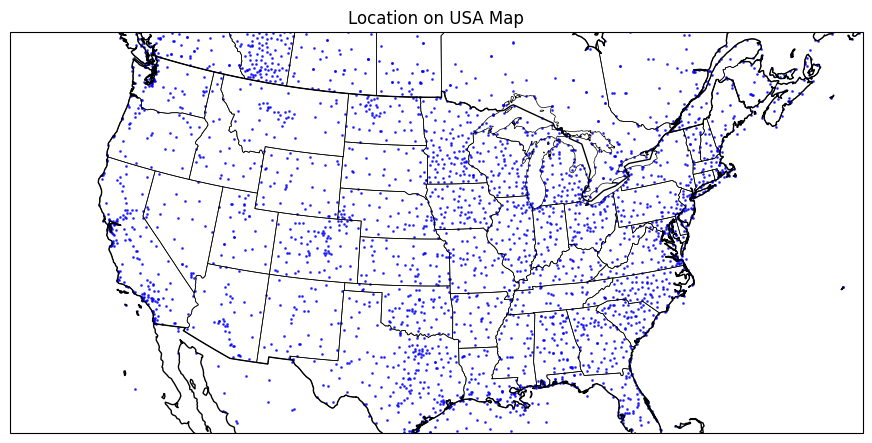

In [3]:
# Extract informations
stations_coords = df[['STATION', 'LATITUDE', 'LONGITUDE']].drop_duplicates().values

# Plot points on map
print_points_on_us_map(latitudes=stations_coords[:, 1], longitudes=stations_coords[:, 2])

___
___
# **Find the closest stations to each fips**
Objective : Reduce dataset size. 

### **Plot fips on US map**

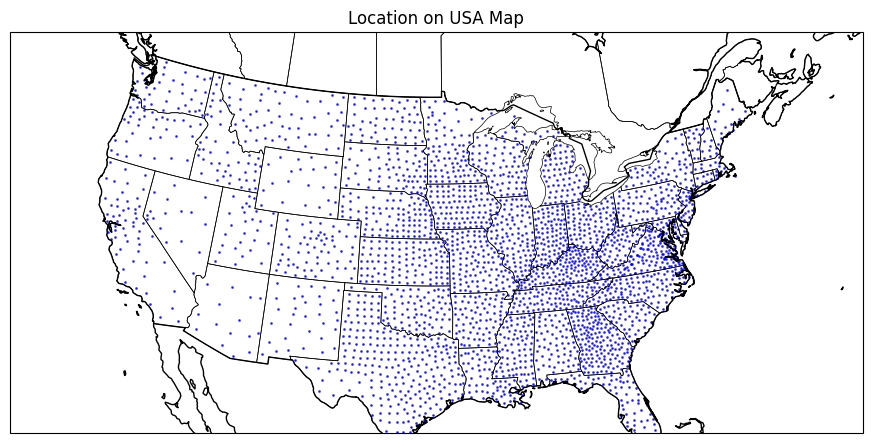

In [4]:
# Open latitude and longitude from fips
df_latlong = pd.read_csv(path_to_latitude_longitude_file)

# Plot points on map
fips_coords = df_latlong[['lat', 'lng']].drop_duplicates().values
print_points_on_us_map(latitudes=fips_coords[:, 0], longitudes=fips_coords[:, 1])

### **Find the closest stations to each fips**

In [5]:
closest_stations = []

for i, row in df_latlong.iterrows():

    # Extract latitude and longitude of the fips
    lat, lon = row['lat'], row['lng']

    # Compute euclidian distance
    diff_x = np.array(stations_coords[:, 1], dtype='float') - lat
    diff_y = np.array(stations_coords[:, 2], dtype='float') - lon
    dists = np.sqrt(diff_x**2 + diff_y**2)

    # Store closest station
    closest = stations_coords[dists.argmin()][0]
    closest_stations.append(closest)

# Store result
dict_closest_station_to_fips = {k:v for k, v in zip(df_latlong['fips_code'].values, closest_stations)}
joblib.dump(dict_closest_station_to_fips, "dict_closest_station_to_fips.joblib")

len(dict_closest_station_to_fips)

3233

___
___
# **Filter and export df**

### **Select only closest stations in df**

In [6]:
print(f"Length before filter: {len(df)} ({df['STATION'].nunique()} stations).")

# Filter
df = df[df['STATION'].isin(closest_stations)].reset_index(drop=True)

print(f"Length after filter : {len(df)} ({df['STATION'].nunique()} stations).")

Length before filter: 36541076 (13572 stations).
Length after filter : 5610098 (1820 stations).


### **Plot closest stations on map**

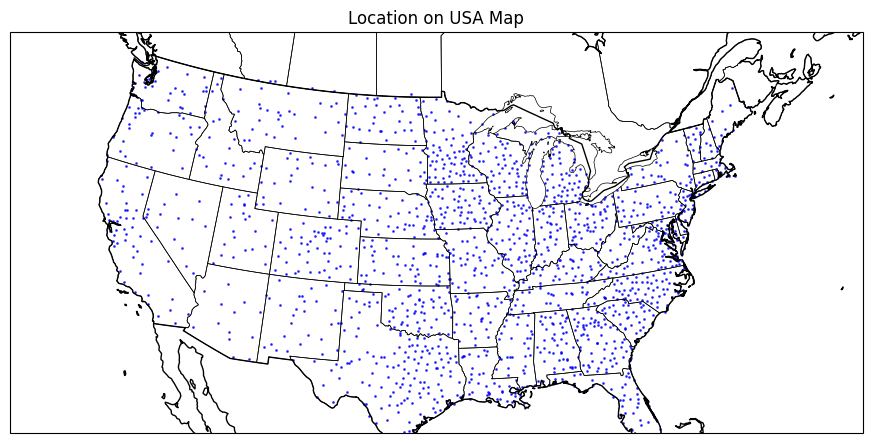

In [7]:
# Extract informations
stations_coords = df[['STATION', 'LATITUDE', 'LONGITUDE']].drop_duplicates().values

# Plot points on map
print_points_on_us_map(latitudes=stations_coords[:, 1], longitudes=stations_coords[:, 2])

### **Export df in CSV**

In [8]:
%%time

# Export in CSV
df.to_csv(output_dirpath + "daily_weather_info.csv", index=False)

# Show
print(df.shape)
df.head()

(5610098, 8)
CPU times: user 32.8 s, sys: 327 ms, total: 33.1 s
Wall time: 33.2 s


,STATION,DATE,LATITUDE,LONGITUDE,TEMP,MXSPD,PRCP,Flag_Thunder
0,72447593909,2015-01-01,38.822102,-94.890266,22.000000,13.0,0.00,0
1,72447593909,2015-01-02,38.822102,-94.890266,30.900000,11.1,0.00,0
2,72447593909,2015-01-03,38.822102,-94.890266,33.900002,6.0,0.00,0
3,72447593909,2015-01-04,38.822102,-94.890266,17.200001,21.0,0.05,0
4,72447593909,2015-01-05,38.822102,-94.890266,12.300000,13.0,0.00,0
